In [1]:
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import random
from imblearn.over_sampling import SMOTE

In [2]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


In [3]:
threshold_num = 0.95

In [4]:
row = cat.iloc[random.randint(0,len(cat))]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time

datetime.datetime(1974, 4, 26, 9, 18)

In [5]:
arrival_time_rel = row['time_rel(sec)']
arrival_time_rel

33480.0

In [6]:
test_filename = row.filename
test_filename

'xa.s12.00.mhz.1974-04-26HR00_evid00144'

In [7]:
#Training

In [8]:
csv_directory = './data/lunar/training/data/S12_GradeA/'
csv_fetch = f'{csv_directory}{test_filename}.csv'
csv_data = pd.read_csv(csv_fetch)
csv_data
csv_data_training = csv_data

In [9]:
data_directory = './data/lunar/training/data/S12_GradeA/'
data_fetch = f'{data_directory}{test_filename}.mseed'
data = read(data_fetch)
print(data)

1 Trace(s) in Stream:
XA.S12.00.MHZ | 1974-04-26T00:00:00.349000Z - 1974-04-26T23:59:58.084849Z | 6.6 Hz, 572386 samples


In [10]:
filtered_data = data.copy()
for trace in filtered_data:
    trace.filter("highpass", freq=1.0)

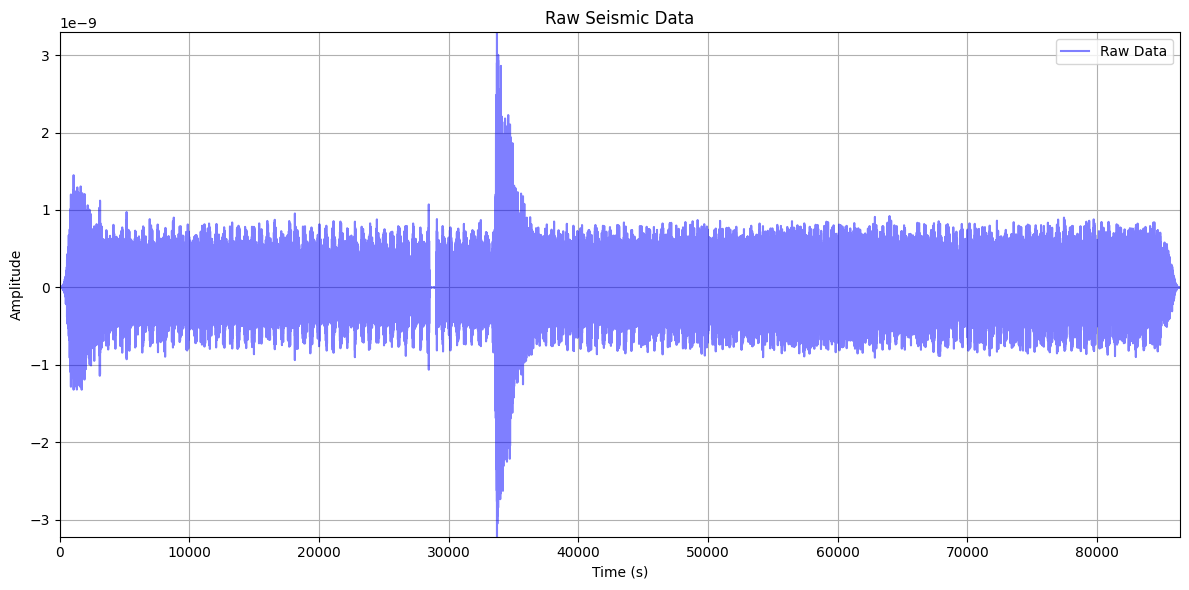

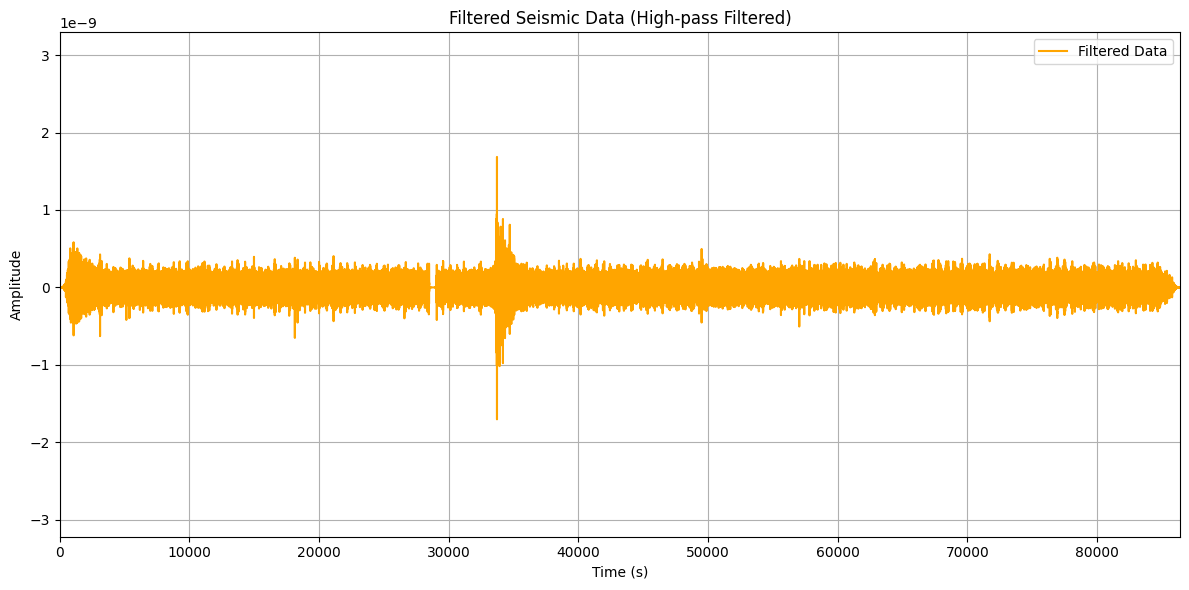

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(data[0].times(), data[0].data, label='Raw Data', alpha=0.5, color='blue')

plt.xlim(data[0].times()[0], data[0].times()[-1])
plt.ylim(np.min(data[0].data), np.max(data[0].data))

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Raw Seismic Data')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(filtered_data[0].times(), filtered_data[0].data, label='Filtered Data', color='orange')

plt.xlim(data[0].times()[0], data[0].times()[-1])
plt.ylim(np.min(data[0].data), np.max(data[0].data)) 

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Filtered Seismic Data (High-pass Filtered)')
plt.legend()
plt.grid()  # Optional: Add grid for better readability
plt.tight_layout()  # Optimize layout
plt.show()

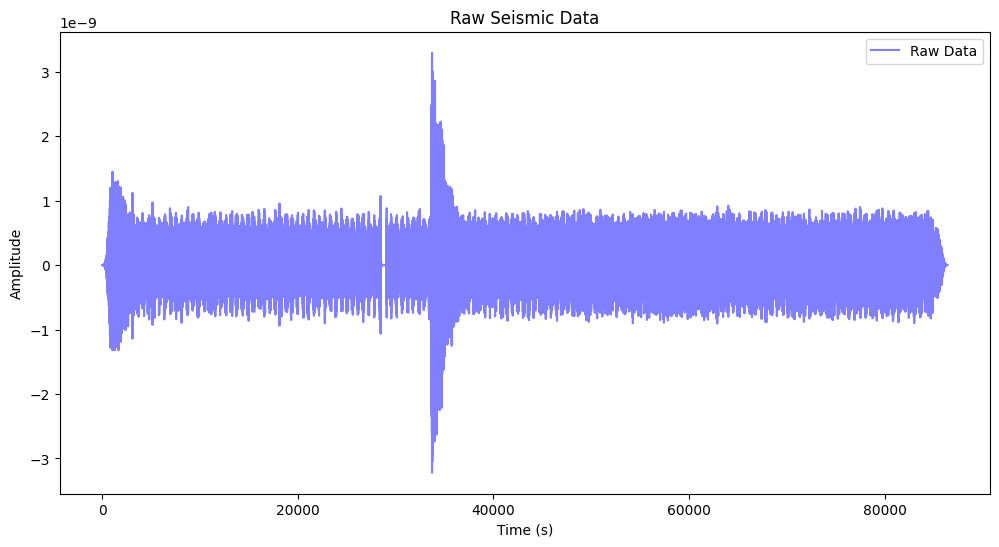

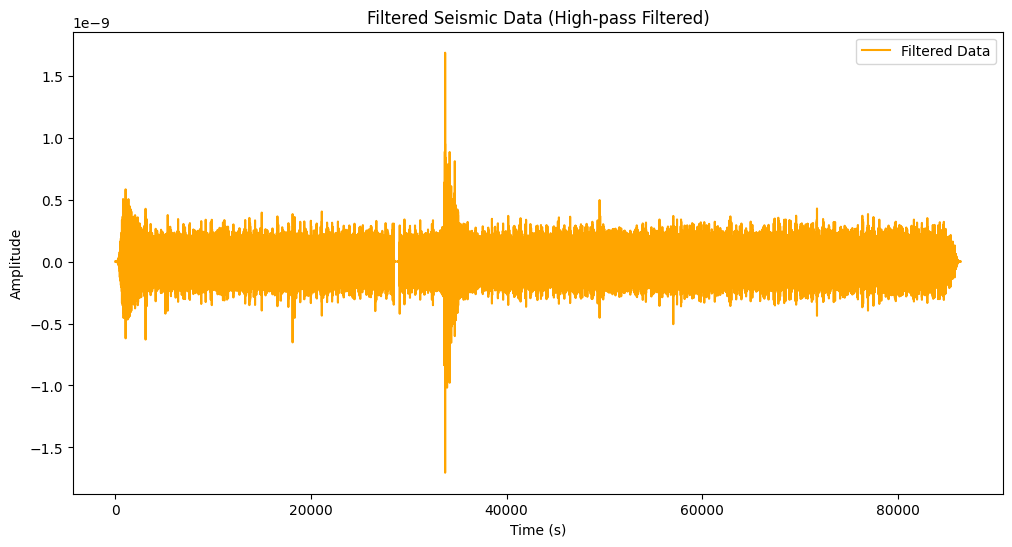

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(data[0].times(), data[0].data, label='Raw Data', alpha=0.5, color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Raw Seismic Data')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(filtered_data[0].times(), filtered_data[0].data, label='Filtered Data', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Filtered Seismic Data (High-pass Filtered)')
plt.legend()
plt.show()

In [13]:
col = csv_data_training.columns
col

Index(['time_abs(%Y-%m-%dT%H:%M:%S.%f)', 'time_rel(sec)', 'velocity(m/s)'], dtype='object')

In [14]:
csv_data_training.head()

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1974-04-26T00:00:00.349000,0.000000,-3.233734e-15
1,1974-04-26T00:00:00.499943,0.150943,-4.005405e-15
2,1974-04-26T00:00:00.650887,0.301887,-4.292104e-15
3,1974-04-26T00:00:00.801830,0.452830,-4.084924e-15
4,1974-04-26T00:00:00.952774,0.603774,-3.581547e-15


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [16]:
threshold_value = csv_data_training['velocity(m/s)'].quantile(threshold_num)

In [17]:
csv_data_training['is_event'] = (csv_data_training['velocity(m/s)'].abs() > threshold_value).astype(int)

In [18]:
csv_data_training

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s),is_event
0,1974-04-26T00:00:00.349000,0.000000,-3.233734e-15,0
1,1974-04-26T00:00:00.499943,0.150943,-4.005405e-15,0
2,1974-04-26T00:00:00.650887,0.301887,-4.292104e-15,0
3,1974-04-26T00:00:00.801830,0.452830,-4.084924e-15,0
4,1974-04-26T00:00:00.952774,0.603774,-3.581547e-15,0
...,...,...,...,...
572381,1974-04-26T23:59:57.481075,86397.132075,5.185162e-17,0
572382,1974-04-26T23:59:57.632019,86397.283019,-6.835137e-16,0
572383,1974-04-26T23:59:57.782962,86397.433962,-9.545392e-16,0
572384,1974-04-26T23:59:57.933906,86397.584906,-1.088459e-15,0


In [19]:
print(csv_data_training['is_event'])

0         0
1         0
2         0
3         0
4         0
         ..
572381    0
572382    0
572383    0
572384    0
572385    0
Name: is_event, Length: 572386, dtype: int32


In [20]:
vc = csv_data_training['is_event'].value_counts()
vc

is_event
0    522975
1     49411
Name: count, dtype: int64

In [21]:
#Testing

In [22]:
csv_directory = './data/lunar/test/data/S16_GradeB/'
test_filename = "xa.s16.00.mhz.1973-12-18HR00_evid00487"
csv_fetch = f'{csv_directory}{test_filename}.csv'
csv_data = pd.read_csv(csv_fetch)
csv_data
csv_data_testing = csv_data

In [23]:
data_directory = './data/lunar/test/data/S16_GradeB/'
test_filename = "xa.s16.00.mhz.1973-12-18HR00_evid00487"
data_fetch = f'{data_directory}{test_filename}.mseed'
data = read(data_fetch)
print(data)

1 Trace(s) in Stream:
XA.S16.00.MHZ | 1973-12-18T00:00:00.227000Z - 1973-12-19T00:00:03.547755Z | 6.6 Hz, 572423 samples


In [24]:
filtered_data = data.copy()
for trace in filtered_data:
    trace.filter("highpass", freq=1.0)

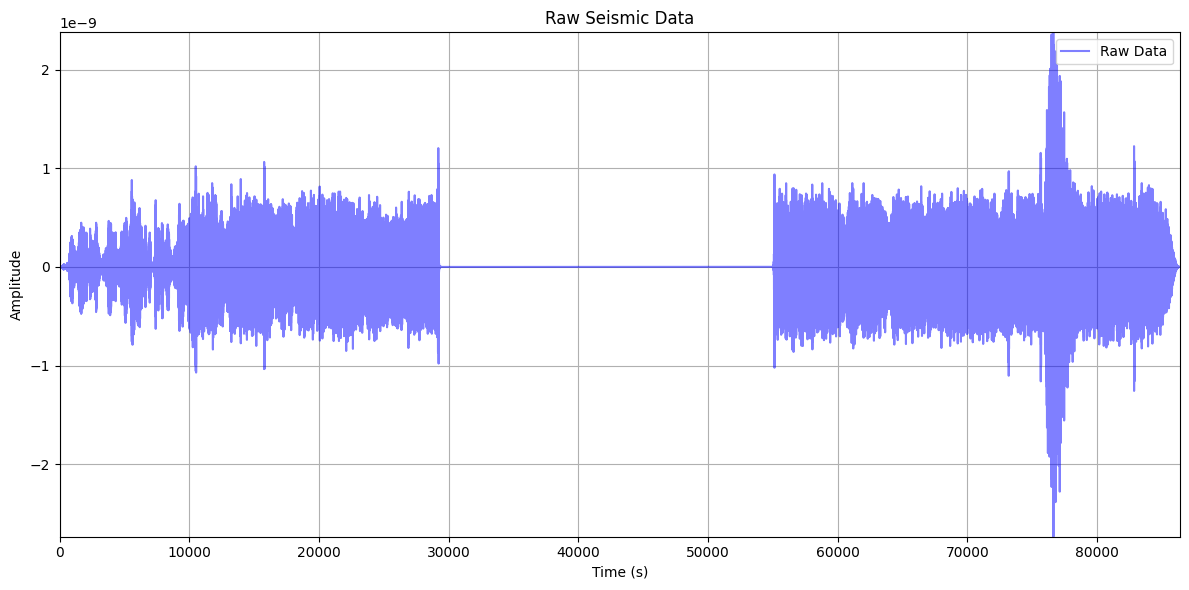

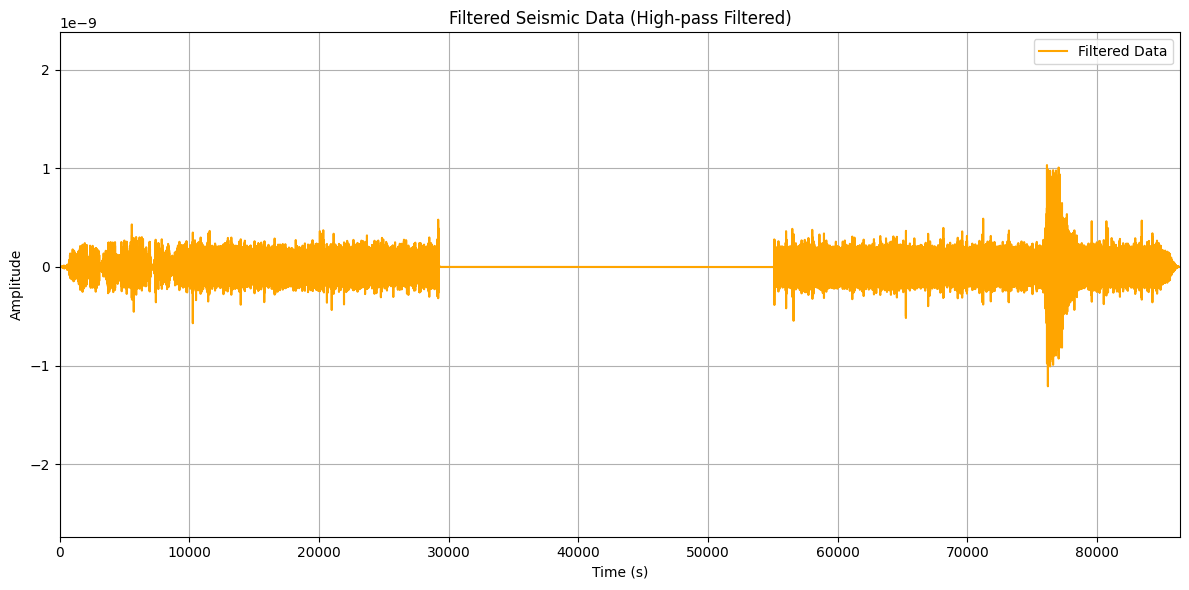

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(data[0].times(), data[0].data, label='Raw Data', alpha=0.5, color='blue')

plt.xlim(data[0].times()[0], data[0].times()[-1])
plt.ylim(np.min(data[0].data), np.max(data[0].data))

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Raw Seismic Data')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(filtered_data[0].times(), filtered_data[0].data, label='Filtered Data', color='orange')

plt.xlim(data[0].times()[0], data[0].times()[-1])
plt.ylim(np.min(data[0].data), np.max(data[0].data)) 

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Filtered Seismic Data (High-pass Filtered)')
plt.legend()
plt.grid()  # Optional: Add grid for better readability
plt.tight_layout()  # Optimize layout
plt.show()

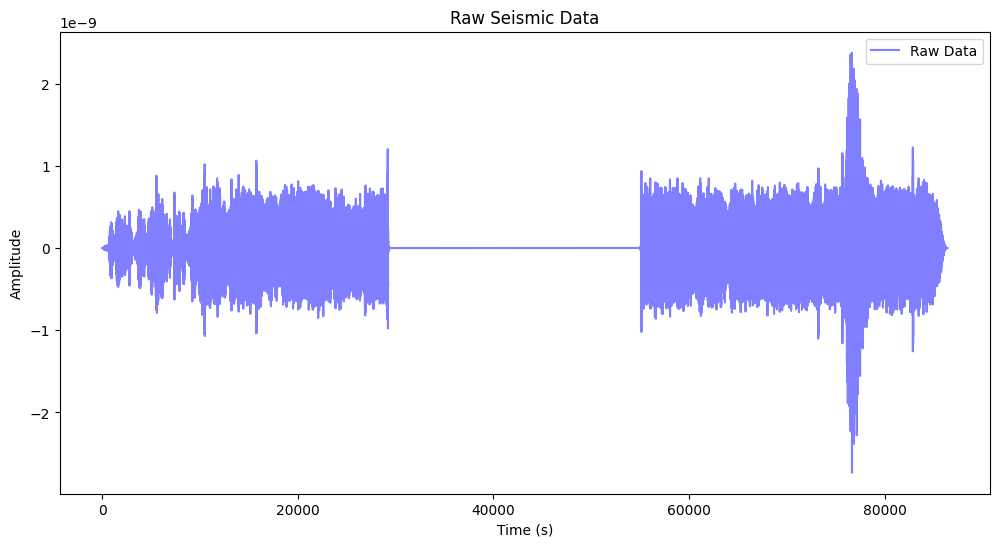

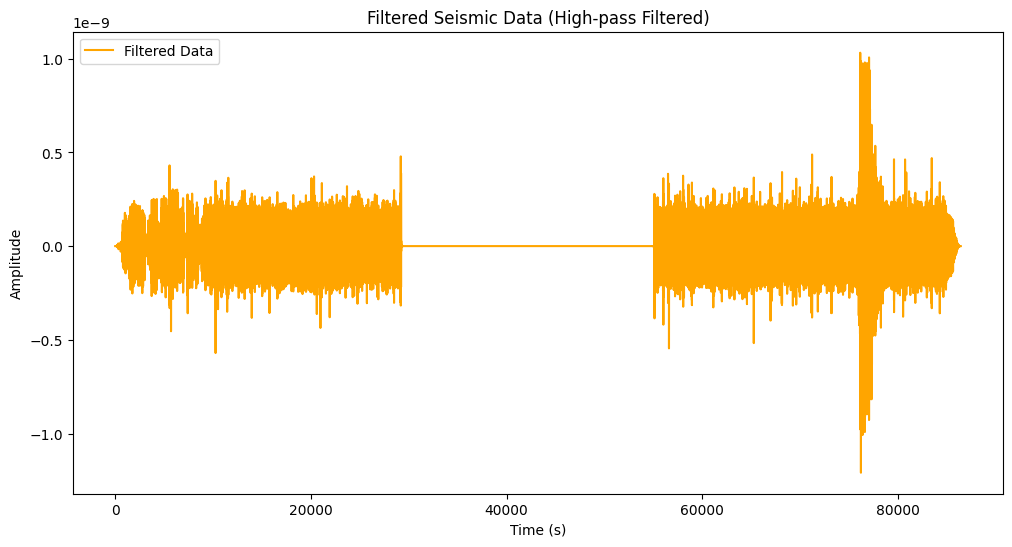

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(data[0].times(), data[0].data, label='Raw Data', alpha=0.5, color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Raw Seismic Data')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(filtered_data[0].times(), filtered_data[0].data, label='Filtered Data', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Filtered Seismic Data (High-pass Filtered)')
plt.legend()
plt.show()

In [27]:
col = csv_data_testing.columns
col

Index(['time_abs(%Y-%m-%dT%H:%M:%S.%f)', 'time_rel(sec)', 'velocity(m/s)'], dtype='object')

In [28]:
csv_data_testing.head()

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1973-12-18T00:00:00.227000,0.000000,0.000000e+00
1,1973-12-18T00:00:00.377943,0.150943,6.089116e-16
2,1973-12-18T00:00:00.528887,0.301887,1.217823e-15
3,1973-12-18T00:00:00.679830,0.452830,1.826735e-15
4,1973-12-18T00:00:00.830774,0.603774,2.435646e-15


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [30]:
threshold_value = csv_data_testing['velocity(m/s)'].quantile(threshold_num)

In [31]:
csv_data_testing['is_event'] = (csv_data_testing['velocity(m/s)'].abs() > threshold_value).astype(int)

In [32]:
csv_data_testing

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s),is_event
0,1973-12-18T00:00:00.227000,0.000000,0.000000e+00,0
1,1973-12-18T00:00:00.377943,0.150943,6.089116e-16,0
2,1973-12-18T00:00:00.528887,0.301887,1.217823e-15,0
3,1973-12-18T00:00:00.679830,0.452830,1.826735e-15,0
4,1973-12-18T00:00:00.830774,0.603774,2.435646e-15,0
...,...,...,...,...
572418,1973-12-19T00:00:02.943981,86402.716981,-2.636839e-14,0
572419,1973-12-19T00:00:03.094925,86402.867925,-3.783444e-14,0
572420,1973-12-19T00:00:03.245868,86403.018868,-4.486758e-14,0
572421,1973-12-19T00:00:03.396811,86403.169811,-6.192964e-14,0


In [33]:
print(csv_data_testing['is_event'])

0         0
1         0
2         0
3         0
4         0
         ..
572418    0
572419    0
572420    0
572421    0
572422    0
Name: is_event, Length: 572423, dtype: int32


In [34]:
vc = csv_data_testing['is_event'].value_counts()
vc

is_event
0    514489
1     57934
Name: count, dtype: int64

In [35]:
csv_data_training

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s),is_event
0,1974-04-26T00:00:00.349000,0.000000,-3.233734e-15,0
1,1974-04-26T00:00:00.499943,0.150943,-4.005405e-15,0
2,1974-04-26T00:00:00.650887,0.301887,-4.292104e-15,0
3,1974-04-26T00:00:00.801830,0.452830,-4.084924e-15,0
4,1974-04-26T00:00:00.952774,0.603774,-3.581547e-15,0
...,...,...,...,...
572381,1974-04-26T23:59:57.481075,86397.132075,5.185162e-17,0
572382,1974-04-26T23:59:57.632019,86397.283019,-6.835137e-16,0
572383,1974-04-26T23:59:57.782962,86397.433962,-9.545392e-16,0
572384,1974-04-26T23:59:57.933906,86397.584906,-1.088459e-15,0


In [36]:
vc1 = csv_data_training['is_event'].value_counts()
vc1

is_event
0    522975
1     49411
Name: count, dtype: int64

In [37]:
csv_data_testing

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s),is_event
0,1973-12-18T00:00:00.227000,0.000000,0.000000e+00,0
1,1973-12-18T00:00:00.377943,0.150943,6.089116e-16,0
2,1973-12-18T00:00:00.528887,0.301887,1.217823e-15,0
3,1973-12-18T00:00:00.679830,0.452830,1.826735e-15,0
4,1973-12-18T00:00:00.830774,0.603774,2.435646e-15,0
...,...,...,...,...
572418,1973-12-19T00:00:02.943981,86402.716981,-2.636839e-14,0
572419,1973-12-19T00:00:03.094925,86402.867925,-3.783444e-14,0
572420,1973-12-19T00:00:03.245868,86403.018868,-4.486758e-14,0
572421,1973-12-19T00:00:03.396811,86403.169811,-6.192964e-14,0


In [38]:
vc2 = csv_data_testing['is_event'].value_counts()
vc2

is_event
0    514489
1     57934
Name: count, dtype: int64

In [39]:
threshold_value = csv_data_training['velocity(m/s)'].quantile(0.97)
print(f'95th Percentile Threshold for Velocity: {threshold_value}')

csv_data_training['target'] = (csv_data_training['velocity(m/s)'] > threshold_value).astype(int)

print("Class distribution in Training Data:\n", csv_data_training['target'].value_counts())

X_train = csv_data_training.drop(columns=['target'])
X_train = X_train.select_dtypes(include=[np.number])
y_train = csv_data_training['target']

smote = SMOTE(sampling_strategy='minority', random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Class distribution in y_train after SMOTE:\n", pd.Series(y_train_resampled).value_counts())

print("X_train data types:\n", X_train_resampled.dtypes)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_resampled, y_train_resampled)

if 'velocity(m/s)' in csv_data_testing.columns:
    csv_data_testing['target'] = (csv_data_testing['velocity(m/s)'] > threshold_value).astype(int)

X_test = csv_data_testing.select_dtypes(include=[np.number])
y_test = csv_data_testing['target'] if 'target' in csv_data_testing.columns else None

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

y_pred = model.predict(X_test)

if y_test is not None:
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", class_report)
else:
    print("No target variable available for evaluation in the test dataset.")

95th Percentile Threshold for Velocity: 5.056956263091177e-10
Class distribution in Training Data:
 target
0    555214
1     17172
Name: count, dtype: int64
Class distribution in y_train after SMOTE:
 target
0    555214
1    555214
Name: count, dtype: int64
X_train data types:
 time_rel(sec)    float64
velocity(m/s)    float64
is_event           int32
dtype: object
Confusion Matrix:
 [[514489  51200]
 [     0   6734]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95    565689
           1       0.12      1.00      0.21      6734

    accuracy                           0.91    572423
   macro avg       0.56      0.95      0.58    572423
weighted avg       0.99      0.91      0.94    572423



In [40]:
print("Accuracy:")
print(accuracy)

Accuracy:
0.9105556555204805


In [41]:
print("Accuracy Percentage:")
print(accuracy*100)

Accuracy Percentage:
91.05556555204805


In [42]:
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[514489  51200]
 [     0   6734]]


In [43]:
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    565689
           1       0.12      1.00      0.21      6734

    accuracy                           0.91    572423
   macro avg       0.56      0.95      0.58    572423
weighted avg       0.99      0.91      0.94    572423

